In [1]:
import pandas as pd
import numpy as np

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

This notebooks loads and cleans up the original data, preparing a data set for the analysis of the probability of completing (redeeming) the promotional offers. First, we do some initial cleaning on the three data sets loaded from json files. We also drop the 2175 users for which there are no data on gender, income, and age (for those users, the age is set to 118 as a placeholder), as we won't be able to use these observations to examine how the probability of completing an offer differs on sociodemographic characteristics.

In [2]:
portfolio = portfolio.rename(columns={'id': 'offer_id', 
                                      'duration': 'offer_duration',
                                      'reward': 'offer_reward'})
portfolio['offer_duration_hours'] = portfolio['offer_duration']*24

# drop users with missing gender and income
print('Original number of users: ' + str(profile.shape[0])) 
profile_cleaned = profile.dropna(subset=['gender', 'income']).rename(
    columns={'id': 'user_id'})
print('The number of users after dropping missing observations: ' + str(profile_cleaned.shape[0])) 

# clarify the gender variable
gender_sub = {'F': 'Female', 'M': 'Male', 'O': 'Other'}
profile_cleaned['gender'] = profile_cleaned['gender'].apply(
    lambda x: ' '.join([gender_sub.get(i, i) for i in x.split()]))

Original number of users: 17000
The number of users after dropping missing observations: 14825


Then, in the data set of transactions, we expand the column *value*, which is a dictionary that includes either the amount of a given transaction or the offer id if the transaction is receiving, viewing, or completing the offer.

In [3]:
transcript = pd.concat([transcript, 
                        pd.DataFrame.from_records(transcript.value.tolist())],
                        axis=1)
transcript['offer_id'].fillna(transcript['offer id'], inplace=True)
transcript = transcript.drop(columns=['offer id', 'value'])

The records of transactions (other than offers) are not linked to offers, and they do not contain offer ids, so we drop them by removing all observations with missing offer id. (We won't need transaction amounts for the analysis of the probability of completing offers anyway.) 

In [4]:
# drop records for users without demographic data
# and records for transactions
transcript_u = transcript[
    transcript.person.isin(profile_cleaned.user_id)
    ].sort_values(by=['person', 'time']).rename(
        columns={'person': 'user_id'}).dropna(subset=['offer_id'])

Then, we create a new data frame that captures information on each offer each user received. Each row in this data frame includes information on a particular offer received by a particular user: when the offer was received, and whether and when it was viewed or completed. To create the data, we loop through all users in the transaction data set, and for each user, we reconstruct what happened with respect to a particular offer by looking at all the transactions with the corresponding offer id in the period when the offer was active. (NOTE: the process might take a while depending on what machine the code is executed.)

One caveat about this recovery process is that in some cases, users were sent the same offer two or more weeks in a row. Given that offer duration is sometimes longer than a week, in some of these cases, two offers with the same id were active simultaneously for a few days, and if offer viewing or completion happened in that specific period, there is no way to determine which of these two identical offers was viewed or completed because the same offer sent multiple times always has the same id. However, this issue is not severe, as in the overwhelming majority of cases, offers were viewed or completed soon after they were sent (or not viewed/completed at all), as the histograms below will show. A manual inspection of the original transactions data set with respect to specific users who had multiple identical offers in a row has also shown that this problem is very rare. 

In [5]:
# three functions to create a user-offer data frame
def get_offer_data(user_data, offer, time_received, current_offer_duration):
    
    '''
    Extract data on a given offer received by a particular user:
    whether and when the offer was viewed and/or completed
    
    Args:
        user_data: a subset of transactions for the specific user
        offer: specific offer id
        time_received: time at which the offer was sent
        current_offer_duration: the duration of the specific offer in hours
        
    Returns: data frame with information on the reception, viewing,
    and completion of a particular offer by a particular user
    '''
    
    # limit transactions to the period in which the offer was active
    offer_data = user_data[
        (user_data.time >= time_received) &
        (user_data.time <= time_received + current_offer_duration) &
        (user_data.offer_id == offer)]
    
    # check whether the offer was completed/redeemed in that period
    offer_completed = int('offer completed' in offer_data.event.tolist())
    
    # check whether the offer was viewed in that period
    offer_viewed = int('offer viewed' in offer_data.event.tolist())
    
    # capture when the offer was completed/viewed
    if offer_completed == 1:
        time_completed = offer_data[
            offer_data.event == 'offer completed'].time.iloc[0]
    else:
        time_completed = np.nan
        
    if offer_viewed == 1:
        time_viewed = offer_data[
            offer_data.event == 'offer viewed'].time.iloc[0]
    else:
        time_viewed = np.nan
        
    # check whether the offer was completed before viewing it
    if offer_completed == 1 & offer_viewed == 1:
        if time_completed < time_viewed:
            offer_viewed_before = 0
        else:
            offer_viewed_before = 1
    elif offer_completed == 1 & offer_viewed == 0:
        offer_viewed_before = 0
    # set to nan if offer not completed
    else:
        offer_viewed_before = np.nan
    
    # combine everything into a data frame            
    user_offer_data = pd.DataFrame(
        {'user_id': offer_data.user_id.unique().tolist(),
         'offer_id': [offer],
         'completed': [offer_completed],
         'viewed': [offer_viewed],
         'viewed_before': [offer_viewed_before],
         'time_received': [time_received],
         'time_viewed': [time_viewed],
         'time_completed': [time_completed],
         'offer_duration': [current_offer_duration]})
    
    return user_offer_data

def check_user_offers(user_data, offer):
    
    '''
    Check how many times a given offer was received by a particular user
    and extract data on offer viewing/completion
    
    Args:
        user_data: a subset of transactions for the specific user
        offer: specific offer id
        
    Returns: data frame with information on the reception, viewing,
    and completion of all offers with a particular id by a particular user
    '''
    
    # extract the duration of the offer in hours from offer metadata
    current_offer_duration = portfolio[
        portfolio.offer_id == offer].offer_duration_hours.item()
    
    # check how many times the user received the same offer
    received_times = user_data[(user_data.event == 'offer received') &
                               (user_data.offer_id == offer)].time.tolist()
    
    # extract offer data
    user_offer_data = [get_offer_data(user_data, offer,
                                      time_point,
                                      current_offer_duration) for
                       time_point in received_times]
    user_offer_data = pd.concat(user_offer_data)
    
    # how many times the same offer was received 
    user_offer_data['offer_count'] = len(received_times)
    user_offer_data['time_points'] = '.'.join(str(x) for x in received_times)
        
    return user_offer_data
        

def clean_offers_by_user(user):
    
    '''
    Get data on all offers received by a particular user
    
    Args:
        user: user id
        
    Returns: data frame with information on the reception, viewing,
    and completion of all offers received by a particular user
    '''
    
    # a data set of all records on offers received, viewed, or completed
    # by a particular user
    user_transactions = transcript_u[transcript_u.user_id == user]
    
    # the ids of all offers received by the user
    user_offers = user_transactions.offer_id.unique().tolist()
    
    # extract data on all offers received by this user
    user_offer_data = [check_user_offers(user_transactions, offer) for 
                       offer in user_offers]
    user_offer_data = pd.concat(user_offer_data)
    
    return user_offer_data

# create the user-offer data frame
offers_by_user = [clean_offers_by_user(user) for user in 
                  transcript_u.user_id.unique().tolist()]
offers_by_user = pd.concat(offers_by_user)

Now that we have the data set on all offers received by all users, we can check how quickly the customers viewed or completed the offers after receiving them. The histograms below show that in the overwhelming majority of cases, the offers were completed in less than a week, and in most cases sooner than that. It took even less time to view the offer in most cases. That increases our confidence in the algorithm that was used above to recover the data on offer viewing/completion.

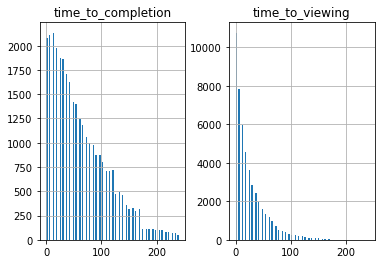

In [6]:
offers_by_user['time_to_completion'] = offers_by_user[
    'time_completed'] - offers_by_user['time_received']
offers_by_user['time_to_viewing'] = offers_by_user[
    'time_viewed'] - offers_by_user['time_received']
offers_by_user[['time_to_completion', 'time_to_viewing']].hist(bins=100)
offers_by_user = offers_by_user.drop(columns=['time_to_completion',
                                              'time_to_viewing'])

Next, we calculate how many offers each user has completed before receiving the current offer. This may be useful to identify users who are generally more likely to complete offers (because they generally spend more or because they are more actively seeking promo offers). This part creates two variables: how many times the user has completed the same offer before and how many times the user has completed any offer before.

In [7]:
offers_by_user = offers_by_user.sort_values(
    by=['user_id', 'offer_id', 'time_received']).reset_index(drop=True)
offers_by_user['same_offer_completed_before'] = offers_by_user.groupby(
    by=['user_id', 'offer_id'])['completed'].cumsum()
offers_by_user['same_offer_completed_before'] = offers_by_user[
    'same_offer_completed_before'] - offers_by_user['completed']
offers_by_user = offers_by_user.sort_values(
    by=['user_id', 'time_received']).reset_index(drop=True)
offers_by_user['any_offer_completed_before'] = offers_by_user.groupby(
    by=['user_id'])['completed'].cumsum()
offers_by_user['any_offer_completed_before'] = offers_by_user[
    'any_offer_completed_before'] - offers_by_user['completed']

Next, we will merge the user-offer data with data on users and create some additional variables, mainly for the purpose of establishing how long one was a member by the time one received a particular offer. The original user data includes a variable *became_member_on* that is a date when the user created a member account. If we assume that the test (sending the offers) began on August 1, 2018, we can calculate how many months one has been a member when they received a specific offer. (This assumption is based on the fact that the latest signing-up date in the data set is at the end of July 2018. However, even if the test started on a later date, this won't affect the conclusions in terms of whether more recent members would be more or less likely to redeem offers.)

In [8]:
# merge with user data
offers_by_user = pd.merge(offers_by_user, profile_cleaned)

# calculate amount of time in months between the start of one's membership
# and receiving the current offer
# assume test started on 8/1/2018
offers_by_user['test_date'] = '20180801' 
offers_by_user['test_date'] = pd.to_datetime(offers_by_user['test_date'], 
                                             format="%Y%m%d")

# calculate dates when offers were received
offers_by_user['offer_date'] = offers_by_user[
    'test_date'] + pd.to_timedelta(offers_by_user.time_received/24, unit='d')
offers_by_user = offers_by_user.drop(columns='test_date')

# calculate the difference in months between offer date and start of membership
offers_by_user['member_date'] = pd.to_datetime(
    offers_by_user['became_member_on'], format="%Y%m%d") 
offers_by_user['member_months'] = 12 * (
    offers_by_user.offer_date.dt.year - 
    offers_by_user.member_date.dt.year) + (
        offers_by_user.offer_date.dt.month - 
         offers_by_user.member_date.dt.month)

Finally, we join the data with the metadata on promotional offers and save the resulting data set for future use.

In [9]:
# join with metadata on offers
offers_by_user = pd.merge(offers_by_user, 
                          portfolio.drop(columns=['offer_duration',
                                                  'offer_duration_hours']), 
                          how='left')

# save data
offers_by_user.to_csv('data/cleaned_offer_data.csv', index=False)